## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [12]:
import matplotlib.pyplot as plt

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [13]:
N = 1000

In [14]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(N)

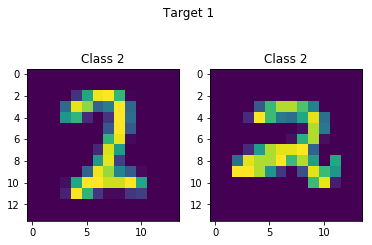

In [38]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0])
axs[0].set_title(f"Class {train_classes[0][0].item()}")
axs[1].imshow(train_input[0][1])
axs[1].set_title(f"Class {train_classes[0][1].item()}")
fig.suptitle(f"Target {train_target[0].item()}")

plt.show()

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

## Network

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.